In [1]:
from network_analysis import *

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
pio.renderers.default = "svg"
import matplotlib.pyplot as plt


In [2]:
data_dir = "./../history/2.4.3/"

edges = pd.read_excel(data_dir + "edges.xls").fillna("")
nodes = pd.read_excel(data_dir + "nodes.xls")

node_list = nodes["斑块编号"].values

edges_list = []
for idx, i in edges.iterrows():
    if i["途径斑块1编号"] == "" and i["途径斑块2编号"] == "":
        edges_list.append([int(i["起点斑块编号"]), int(i["终点斑块编号"])])
    elif i["途径斑块2编号"] == "":
        edges_list.append([i["起点斑块编号"], int(i["途径斑块1编号"])])
        edges_list.append([int(i["途径斑块1编号"]), i["终点斑块编号"]])
    else:
        edges_list.append([i["起点斑块编号"], int(i["途径斑块2编号"])])
        edges_list.append([int(i["途径斑块2编号"]), int(i["途径斑块1编号"])])
        edges_list.append([int(i["途径斑块1编号"]), i["终点斑块编号"]])

E_list = nodes["MESC指数"].values

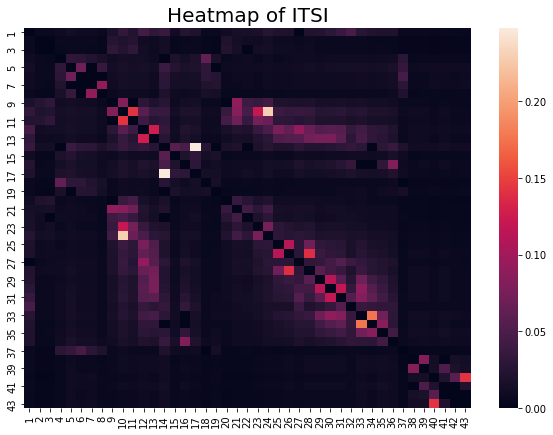

In [3]:
G = generate_graph(node_list, edges_list)

df_rst = pd.DataFrame([], index=node_list, columns=node_list)
one_div_one_plus_dk = calculate_distance(nodes)

for i in node_list:
    for j in node_list:
        if i != j:
            val = calculate_ITSI(G, i, j, one_div_one_plus_dk, E_list)
            df_rst.loc[i, j] = val

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax = sns.heatmap(df_rst.fillna(0), linewidth=0.001)
ax.set_title("Heatmap of ITSI", fontsize=20)
fig.savefig("./../results/2.4.3/Heatmap_of_ITSI.png")


In [4]:
df_rst = pd.read_excel("./../results/2.4.3/result_rank_new.xls")

df_rst_rk1 = df_rst.query("rank<=11 & rank>=1")
G1 = gen_new_graph(df_rst_rk1)
df_rst_rk2 = df_rst.query("rank<=50 & rank>=12")
G2 = gen_new_graph(df_rst_rk2)
df_rst_rk3 = df_rst.query("rank<=152 & rank>=51")
G3 = gen_new_graph(df_rst_rk3)
df_rst_rk4 = df_rst.query("rank<=332 & rank>=153")
G4 = gen_new_graph(df_rst_rk4)
df_rst_rk5 = df_rst.query("rank<=902 & rank>=333")
G5 = gen_new_graph(df_rst_rk5)


fig = plot_network_graph(G, nodes)
fig.write_image(f"./../results/2.4.3/landscape_origin.png")

idx = 1
for G_new, color in zip([G1, G2, G3, G4, G5], ['darkred', 'darkblue', 'darkcyan', 'darkgoldenrod', 'grey']):
    print(G, color)
    fig = add_graph(fig, G_new, nodes, color=color)
    fig.write_image(f"./../results/2.4.3/landscape_add_{idx}.png")
    idx += 1


Graph with 43 nodes and 19 edges darkred
Graph with 43 nodes and 19 edges darkblue
Graph with 43 nodes and 19 edges darkcyan
Graph with 43 nodes and 19 edges darkgoldenrod
Graph with 43 nodes and 19 edges grey


In [5]:
import networkx as nx

def diameter(G):
    diam = []
    for g in nx.connected_components(G):
        g = G.subgraph(g) 
        diam.append(nx.diameter(g))
    return max(diam)

def avg_path_len(G):
    avg_len = []
    nums_nodes = []
    for g in nx.connected_components(G):
        g = G.subgraph(g) 
        avg_len.append(nx.average_shortest_path_length(g))
        nums_nodes.append(nx.number_of_nodes(g))
        
    len_ = np.sum([x*y*(y-1)/2 for x,y in zip(avg_len, nums_nodes)]) / np.sum([x*(x-1)/2 for x in nums_nodes])
    
    return len_

def merge_graph(G, H):
    U=nx.Graph()
    U.add_edges_from(list(G.edges()) + list(H.edges()))
    U.add_nodes_from(list(G.nodes()) + list(H.nodes())) 
    return U

rst = []
G_total = nx.Graph()

for g in [G, G1, G2, G3, G4, G5]:
    
    G_total = merge_graph(G_total, g)
    nodes_num = nx.number_of_nodes(G_total)
    edges_num = nx.number_of_edges(G_total)
    clustering = nx.average_clustering(G_total)
    avg_degree = np.mean(list(dict(nx.degree(G_total)).values()))
    diam = diameter(G_total)
    avg_len = avg_path_len(G_total)
    component_num = nx.number_connected_components(G_total)

    rst.append([nodes_num, edges_num, diam, avg_degree, clustering, avg_len, component_num])

rst = pd.DataFrame(rst, columns=["网络节点数", "网络连接数", "网络直径", "网络平均度", "网络平均路径长度", "网络聚类系数", "网络连通分量个数"])
rst.to_csv("./../results/2.4.3/network_statistic.csv", index=False)